## Updates to table 1

Changes to TF results:
1. Add class weights
2. Add LR scheduler
3. Take average of all predictions instead of just final layer

Changes to PyTorch:
1. Add same LR scheduler as TF
2. Batch size down from 50 to 10 (consistent with TF)
3. Increase epochs from 100 to 300 (consistent with TF)
4. Using all same genes (not only genes for which we have graph connections from humanbase, where ~150 were missing compared to Pnet TF)
5. Added options for class weights
6. Added options for average predictions instead of just final layer

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

def get_metrics(ys,preds):
    fpr, tpr, _ = roc_curve(ys, preds)
    auc_value = auc(fpr, tpr)

    return fpr, tpr, auc_value, ys, preds

In [2]:
root="/scratch/cp3759/cancer_reprod_data/may2024/"

In [3]:
with open(root+"tf.p", 'rb') as handle:
    tf=pickle.load(handle)

with open(root+"torch_noweight.p", 'rb') as handle:
    noweight=pickle.load(handle)

with open(root+"torch_weight.p", 'rb') as handle:
    weight=pickle.load(handle)

with open(root+"torch_weight_avg.p", 'rb') as handle:
    weight_avg=pickle.load(handle)

In [4]:
tfs={"auc":[],
           'accuracy':[],
           'aupr':[], 
           'f1':[],
           'precision':[],
           'recall':[]}
noweights={"auc":[],
           'accuracy':[],
           'aupr':[], 
           'f1':[],
           'precision':[],
           'recall':[]}

weights={"auc":[],
           'accuracy':[],
           'aupr':[], 
           'f1':[],
           'precision':[],
           'recall':[]}

weights_avg={"auc":[],
           'accuracy':[],
           'aupr':[], 
           'f1':[],
           'precision':[],
           'recall':[]}

for aa in range(len(noweight)):
    for key in noweights.keys():
        tfs[key].append(tf[aa][key])
        noweights[key].append(noweight[aa][key])
        weights[key].append(weight[aa][key])
        weights_avg[key].append(weight_avg[aa][key])

In [5]:
def plot_hists(dict1,dict2,labels=["dict1","dict2"],suptitle=None):
    keylist=list(dict1.keys())
    plt.figure(figsize=(14,10))
    if suptitle:
        plt.suptitle(suptitle)
    for aa in range(len(keylist)):
        mins=min(np.min(dict1[keylist[aa]]),np.min(dict2[keylist[aa]]))
        maxs=max(np.max(dict1[keylist[aa]]),np.max(dict2[keylist[aa]]))
        plt.subplot(3,3,aa+1)
        plt.title(keylist[aa])
        plt.hist(dict1[keylist[aa]],alpha=0.5,label=labels[0],range=(mins,maxs),bins=25);
        plt.hist(dict2[keylist[aa]],alpha=0.5,label=labels[1],range=(mins,maxs),bins=25);
    plt.legend()
    plt.tight_layout()

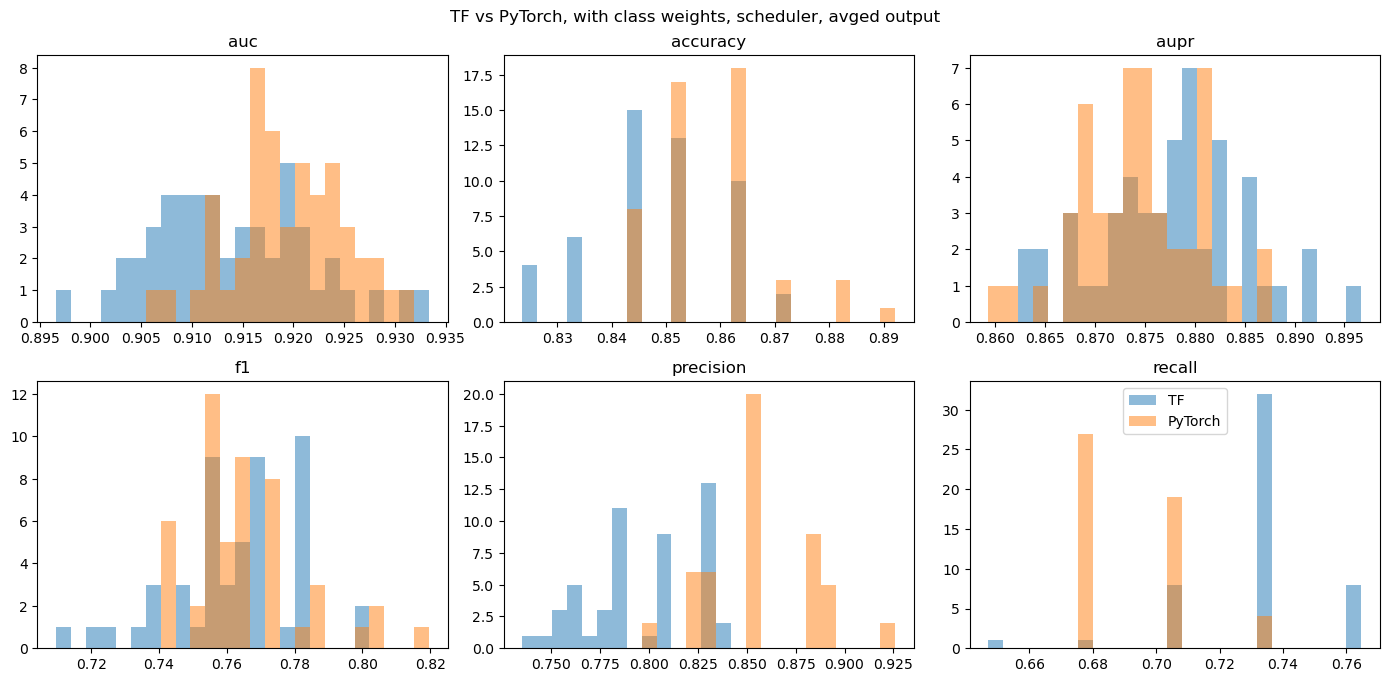

In [6]:
plot_hists(tfs,weights_avg,["TF","PyTorch"],"TF vs PyTorch, with class weights, scheduler, avged output")

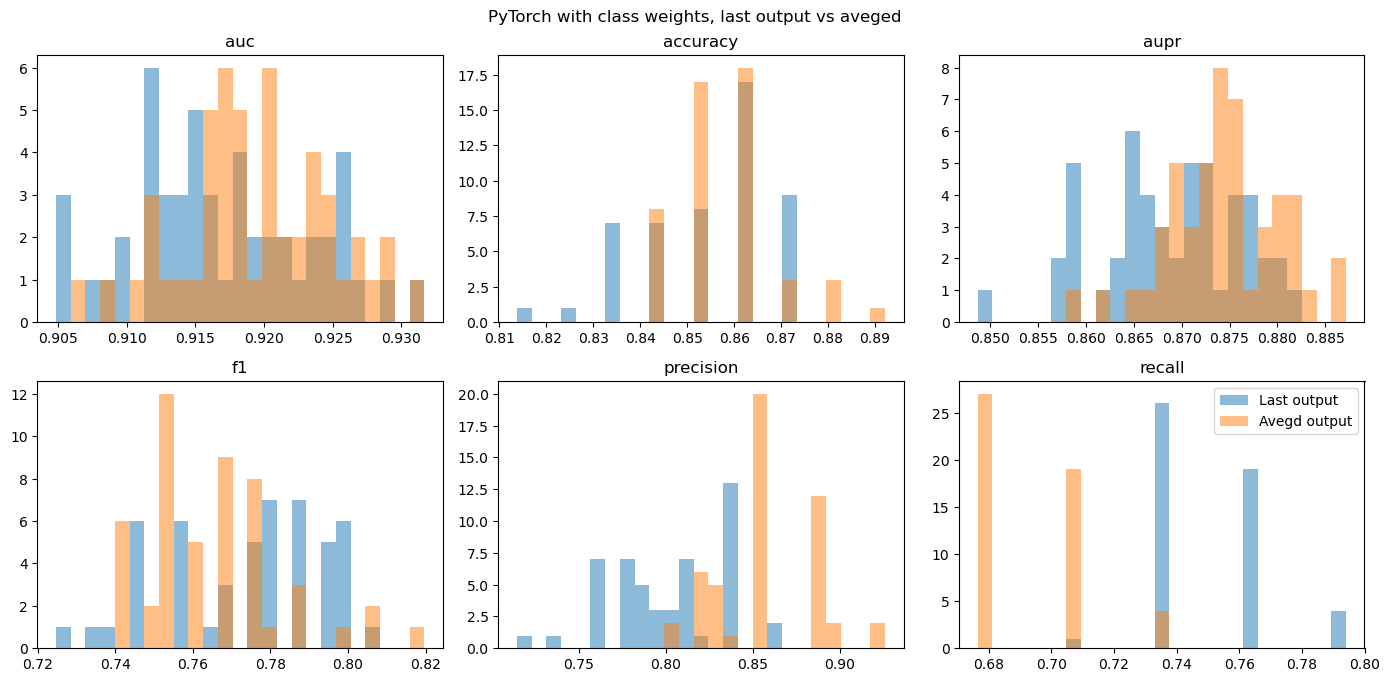

In [7]:
plot_hists(weights,weights_avg,["Last output","Avegd output"],"PyTorch with class weights, last output vs aveged")

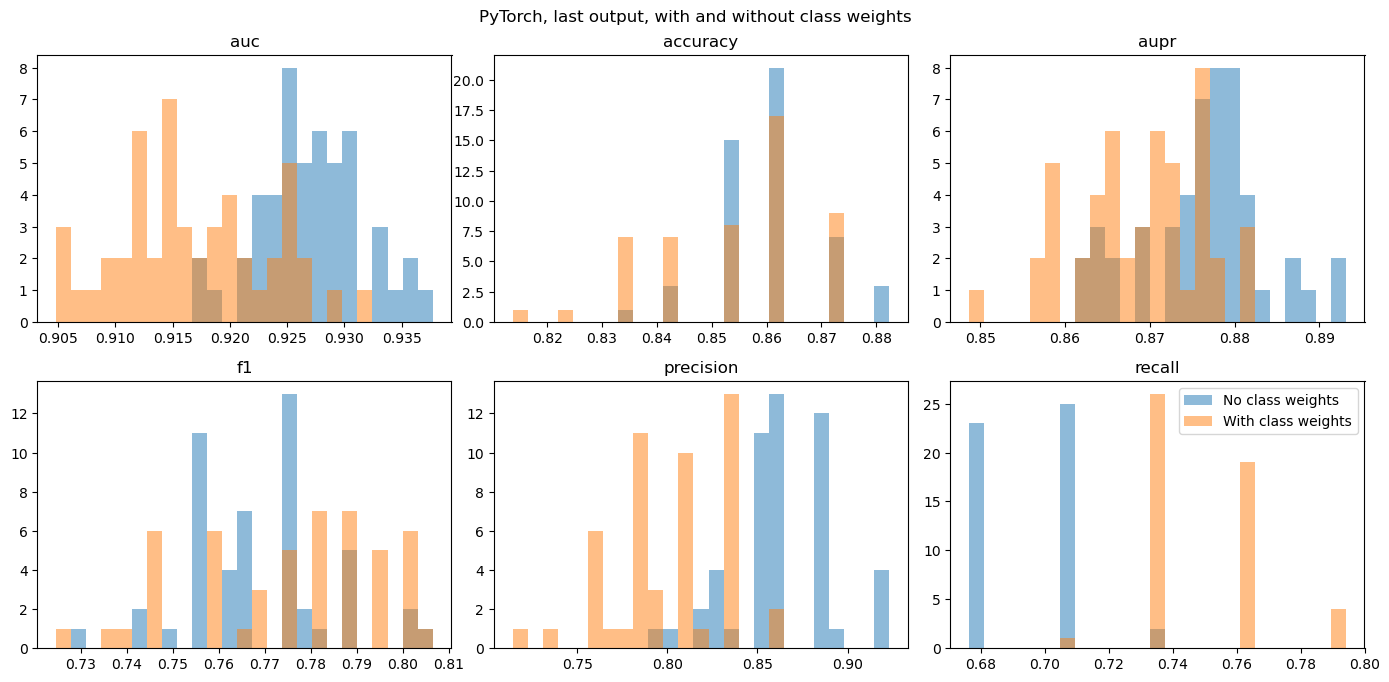

In [8]:
plot_hists(noweights,weights,["No class weights","With class weights"],"PyTorch, last output, with and without class weights")

In [9]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

## Get graph results

def get_graph_stats(graph_string):
    ## Graph results
    #var_string="/mnt/home/cpedersen/Codes/cancer-net/demos/variance_May"
    with open('/scratch/cp3759/cancer-net/wandb_runs/init_variance/%s_variance_no_early.p' % graph_string, 'rb') as handle:
        graph_list=pickle.load(handle)

    avg_dict={'auc':[],
          'accuracy':[],
          'f1':[],
          'precision':[],
           'aupr':[],
          'recall':[]}
    std_dict={'auc':[],
          'accuracy':[],
          'f1':[],
          'precision':[],
           'aupr':[],
          'recall':[]}

    key2key={'auc':'test auc',
             'accuracy':'test acc',
             'f1':'test f1',
             'precision':'test precision',
             'aupr':'test aupr',
             'recall':'test recall'}

    for aa in range(len(graph_list)):
        for key in avg_dict.keys():
            avg_dict[key].append(graph_list[aa][key2key[key]])
    for key in avg_dict.keys():
        std_dict[key]=IQR(avg_dict[key])
        avg_dict[key]=np.median(avg_dict[key])
    #gat_torch_dicts_avg.append(avg_dict)
    #gat_torch_dicts_std.append(std_dict)
    return avg_dict, std_dict

gcn_avg, gcn_std=get_graph_stats("GCN")
#gat_avg, gat_std=get_graph_stats("GAT") ## Old GAT
gatn_avg, gatn_std=get_graph_stats("GAT")
metalayer_avg, metalayer_std=get_graph_stats("MetaLayer")

graph_avg_list=[gcn_avg,gatn_avg,metalayer_avg]
graph_std_list=[gcn_std,gatn_std,metalayer_std]

In [10]:
results={"Model":[],
         "Metric":[],
         "value":[],
         "err":[]}

## Add paper results by hand
results["Model"].append("       P-NET paper")
results["Metric"].append("accuracy")
results["value"].append(0.838)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("auc")
results["value"].append(0.928)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("aupr")
results["value"].append(0.881)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("f1")
results["value"].append(0.755)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("precision")
results["value"].append(0.75)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("recall")
results["value"].append(0.763)
results["err"].append(0)

In [11]:
for key in tfs.keys():
    results["Model"].append("      Pnet TF +W+A")
    results["Metric"].append(key)
    results["value"].append(np.median(tfs[key]))
    results["err"].append(IQR(tfs[key]))

for key in noweights.keys():
    results["Model"].append("     PyTorch")
    results["Metric"].append(key)
    results["value"].append(np.median(noweights[key]))
    results["err"].append(IQR(noweights[key]))

for key in weights.keys():
    results["Model"].append("    PyTorch +W")
    results["Metric"].append(key)
    results["value"].append(np.median(weights[key]))
    results["err"].append(IQR(weights[key]))

for key in weights_avg.keys():
    results["Model"].append("   PyTorch +W+A")
    results["Metric"].append(key)
    results["value"].append(np.median(weights_avg[key]))
    results["err"].append(IQR(weights_avg[key]))

In [12]:
## Add graph results

graph_strings=[" GCN","GAT","MetaLayer"]
for aa in range(len(graph_strings)):
    for key in graph_avg_list[aa].keys():
        results["Model"].append(graph_strings[aa])
        results["Metric"].append(key)
        results["value"].append(graph_avg_list[aa][key])
        results["err"].append(graph_std_list[aa][key])

/state/partition1/job-47043345/ipykernel_1889449/3018911212.py:2: FutureWarning: The provided callable <function sum at 0x14a2fc5f7600> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)


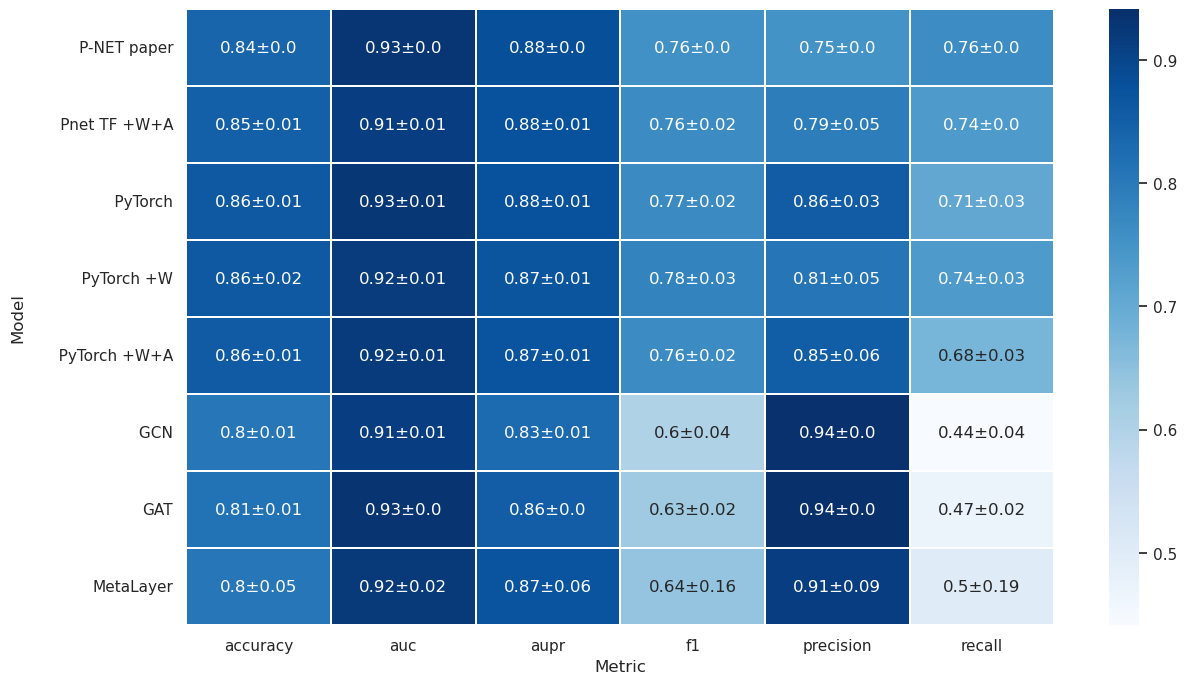

In [13]:
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
noweight[0].keys()

In [ ]:
[keylist[aa]]

In [ ]:
## Get pnet tf results

with open('/home/cp3759/Projects/cancer-net/demos/orig_pnet.pkl', 'rb') as handle:
    orig=pickle.load(handle)
    
orig_np=orig['P-net'].to_numpy()

test_acc=[]
test_aupr=[]
test_f1=[]
test_precision=[]
test_recall=[]

for aa in range(1,61,2):
    fpr_test, tpr_test, test_auc, ys, outs=get_metrics(orig_np[:,-1],orig_np[:,aa])
    test_acc.append(accuracy_score(ys, outs > 0.5))
    test_aupr.append(average_precision_score(ys, outs))
    test_f1.append(f1_score(ys, outs > 0.5))
    test_precision.append(precision_score(ys, outs > 0.5))
    test_recall.append(recall_score(ys, outs > 0.5))

In [ ]:
## Batch size 50, seperate pnet dataset, WITHOUT class weights
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
## Get pnet torch results

pnet_torch_dicts_avg=[]
pnet_torch_dicts_std=[]
for aa in range(2,7):
    pnet_string="pnet_results.h%d_new_noweight.torch.pkl" % aa
    with open(pnet_string, 'rb') as fp:
        pnets = pickle.load(fp)
    avg_dict={'auc':[],
          'accuracy':[],
          'f1':[],
          'precision':[],
           'aupr':[],
          'recall':[]}
    std_dict={'auc':[],
          'accuracy':[],
          'f1':[],
          'precision':[],
           'aupr':[],
          'recall':[]}
    for aa in range(len(pnets)):
        for key in avg_dict.keys():
            avg_dict[key].append(pnets[aa][key])
    for key in avg_dict.keys():
        std_dict[key]=np.std(avg_dict[key])
        avg_dict[key]=np.median(avg_dict[key])
    pnet_torch_dicts_avg.append(avg_dict)
    pnet_torch_dicts_std.append(std_dict)

In [ ]:
## NB including spaces at the front of strings to get the desired order in the pivot_table - will sort alphabetically by default

results={"Model":[],
         "Metric":[],
         "value":[],
         "err":[]}


## Add paper results by hand
results["Model"].append("       P-NET paper")
results["Metric"].append("accuracy")
results["value"].append(0.838)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("auc")
results["value"].append(0.928)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("aupr")
results["value"].append(0.881)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("f1")
results["value"].append(0.755)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("precision")
results["value"].append(0.75)
results["err"].append(0)

results["Model"].append("       P-NET paper")
results["Metric"].append("recall")
results["value"].append(0.763)
results["err"].append(0)


## Populate pnet tf results
results["Model"].append("      P-NET tf")
results["Metric"].append("accuracy")
results["value"].append(np.mean(test_acc))
results["err"].append(np.std(test_acc))

results["Model"].append("      P-NET tf")
results["Metric"].append("auc")
results["value"].append(np.mean(test_auc))
results["err"].append(np.std(test_auc))

results["Model"].append("      P-NET tf")
results["Metric"].append("aupr")
results["value"].append(np.mean(test_aupr))
results["err"].append(np.std(test_aupr))

results["Model"].append("      P-NET tf")
results["Metric"].append("f1")
results["value"].append(np.mean(test_f1))
results["err"].append(np.std(test_f1))

results["Model"].append("      P-NET tf")
results["Metric"].append("precision")
results["value"].append(np.mean(test_precision))
results["err"].append(np.std(test_precision))

results["Model"].append("      P-NET tf")
results["Metric"].append("recall")
results["value"].append(np.mean(test_recall))
results["err"].append(np.std(test_recall))



for aa in range(len(pnet_torch_dicts_avg)):
    for key in pnet_torch_dicts_avg[aa].keys():
        model_string="  "
        for bb in range(aa):
            model_string=" "+model_string
        results["Model"].append(model_string+"P-NET torch (n=%d)" % int(aa+2))
        results["Metric"].append(key) 
        results["value"].append(pnet_torch_dicts_avg[aa][key])
        results["err"].append(pnet_torch_dicts_std[aa][key])
        
graph_strings=[" GCN","GAT","MetaLayer"]
for aa in range(len(graph_strings)):
    for key in graph_avg_list[aa].keys():
        results["Model"].append(graph_strings[aa])
        results["Metric"].append(key)
        results["value"].append(graph_avg_list[aa][key])
        results["err"].append(graph_std_list[aa][key])

In [ ]:
## Batch size 50, seperate pnet dataset, WITHOUT class weights
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
## Batch size 50, seperate pnet dataset, with class weights
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()

In [ ]:
df=pd.DataFrame(results)
table = pd.pivot_table(df,values=['value','err'],columns='Metric',index='Model',aggfunc=np.sum)
table.sort_index(level=0, ascending=True, inplace=True)
sns.set (rc = {'figure.figsize':(14, 8)})
hm=sns.heatmap(table['value'],annot=table['value'].round(2).astype(str)+'±'+table['err'].round(2).astype(str),fmt='',linewidths=0.1,cmap="Blues")
fig=hm.get_figure()
fig.savefig("table1.pdf")